# Data preprocessing

In [96]:
%load_ext autoreload
%autoreload 2
import numpy as np #scientific library
import scipy #scientific library
import scipy.io.wavfile
import sys, os #file reading, directory parsing routines
import matplotlib #to plot
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Audio file reading 

We can use scipy.io to read and write audio files, without any external library. 
In this example we read a stereo file of shape (132299, 2), where the first dimension is the time and the second represents the left and right channels.

(132299, 2)


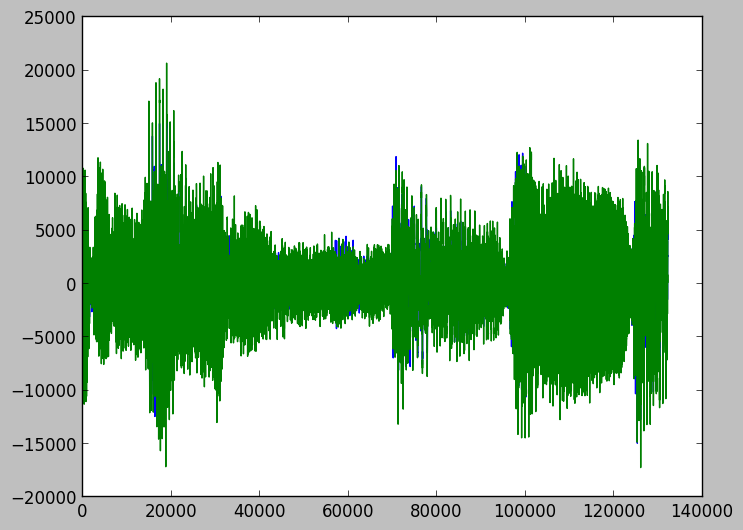

In [97]:
path_to_irmas = './IRMAS-Sample/'

#read audio file
audio_file = '001__[vio][nod][cou_fol]2194__1.wav'
sampleRate, audioObj = scipy.io.wavfile.read(os.path.join(path_to_irmas,'Training','vio',audio_file)) 

print audioObj.shape
plt.plot(audioObj)
plt.show()

As you can see in the plot above, the array is not normalized.

We included a function to read an audio file in util.py, which does this normalization step and also returns the bitrate. 

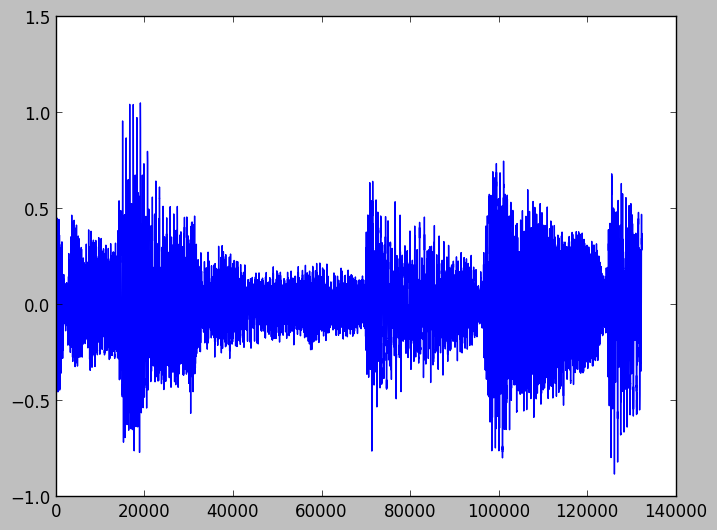

In [98]:
import util

audio, sampleRate, bitrate = util.readAudioScipy(os.path.join(path_to_irmas,'Training','vio',audio_file)) 

plt.plot(audio.sum(axis=1))
plt.show()

If a single channel audio is desired, we can sum the two channels: audio.sum(axis=1)

### Feature computation

We extract features from audio which can be used for training the neural network.

In transform.py you can find a function which computes the Short-term Fourier transform (STFT) of a single-channel audio. The STFT spectrogram is computed for overlapping windows comprising nfft=1024 samples (0.011s). The overlap between these windows is hopsize=512 samples (0.022s).

In [99]:
import transform

spectrogram = transform.stft_norm(audio.sum(axis=1), window=np.hanning(1024), hopsize=512, nfft=1024, fs=float(sampleRate))

spectrogram.shape 


(261, 513)

The function returns 261 vectors for each overlapping frame. Each vector has a feature size of 513.

Usually, we discard the phase, and we obtain the magnitude spectrogram (real numbers).

We also need to normalize by the size of the window. 

In [100]:
print spectrogram[0,0]
mag = np.abs(spectrogram)
print mag[0,0]

mag = mag  / np.sqrt(1024) #normalization
mag.shape

(7.34953326163+0j)
7.34953326163


(261, 513)

Let's plot this spectrogram as an image with matplotlib. 

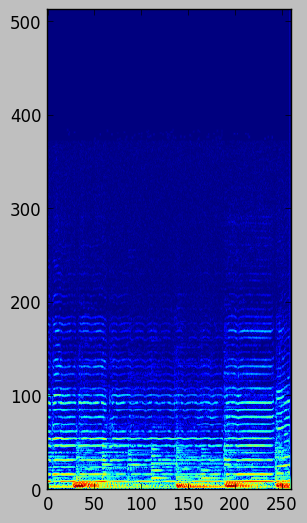

In [101]:
#print plt.style.available
plt.style.use('classic')
plt.imshow(np.log10(1+100*mag).T,interpolation='none', origin='lower')
plt.show()

One can easily distinguish evenly-spaces lines which correspond to harmonic partials of a played instrument note. Take a look at how different notes appear in the image and what is the relation between the harmonic partials. We will try to learn this information from spectrograms to discriminate between instruments. 

There are many more time-frequency representations than the STFT, some of them relying on the computation of STFT, as the mel spectrogram, widely used in speech processing. 

To obtain a mel spectrogram we need to obtain a set of mel filters. We can use librosa for that and we included the mel function from this library. 

In [102]:
mel_basis = transform.mel(sampleRate, n_fft=1024, n_mels=96, fmin=0, fmax=float(sampleRate)/2, htk=False,norm=1)
mel_basis.shape      

(96, 513)

Then we multiply the STFT magnitude spectrogram with the mel filters to obtain the mel spectrogram.

Be careful with the dimensions. Some library consider first dimension time and frequency the second, while this might change for other libraries.

In [103]:
melspec = np.dot(mel_basis, mag.T)
melspec.shape

(96, 261)

Let's plot the mel spectrogram. 
As you can see we reduced the number of features from 513 to 96 and we put more emphasis on the lower frequencies which are better discriminated by the human perception. 

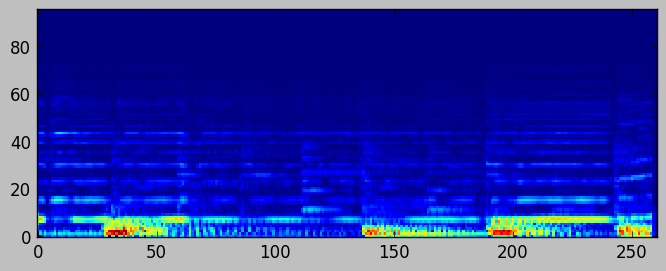

In [104]:
plt.imshow(np.log10(1+100*melspec),interpolation='none', origin='lower')
plt.show()

Next, we save the mel spectrogram to a binary file. We also need to save the shape to a text file, so we can reshape the numpy array when we load the file.
This way of saving data to disk is faster than using pickle or npz files. 

The functions saveTensor and loadTensor can be found in util.py .  

In [105]:
feature_dir_train = os.path.join(path_to_irmas,'features','Training')
if not os.path.exists(feature_dir_train):
    os.makedirs(feature_dir_train)

#save the features to file
melspec.tofile(os.path.join(feature_dir_train,audio_file.replace('.wav','.data')))
#load the features from file
melspecin = np.fromfile(os.path.join(feature_dir_train,audio_file.replace('.wav','.data')))
print 'input spectrogram shape '+str(melspecin.shape)
#we need to save the shape
melspecin = melspecin.reshape(melspec.shape)

input spectrogram shape (25056,)


In transform.py we provide a class that does this feature computation for you: transformMEL. This class has an associated method compute_transform which can compute the mel spectrogram and save it to a '.data' file. 

In [106]:
from transform import transformMEL
tr = transformMEL(bins=96, frameSize=1024, hopSize=512)

Let's compute the training features for all the audio files in the training dataset. 
We go through the instrument list and we read all the wave files from the corresponding directories. Then, we compute the features using compute_transform. 
We also need to save the labels for each sound example.

The suffix in compute_transform is used to discriminate between various features. In this case we use '_mel_' for mel spectrogram and '_label_' for the label associated with the instrument. 

In [107]:
d=os.path.join(path_to_irmas,'Training')
instruments = sorted(filter(lambda x: os.path.isdir(os.path.join(d, x)), os.listdir(d)))

for count,inst in enumerate(instruments):
    for f in os.listdir(os.path.join(d,inst)):
        if os.path.isfile(os.path.join(d,inst, f)) and f.endswith('.wav'):
            audio, sampleRate, bitrate = util.readAudioScipy(os.path.join(d,inst,f)) 
            tr.compute_transform(audio.sum(axis=1),out_path=os.path.join(feature_dir_train,f.replace('.wav','.data')),suffix='_mel_',sampleRate=sampleRate)
            util.saveTensor(np.array([count],dtype=float),out_path=os.path.join(feature_dir_train,f.replace('.wav','.data')),suffix='_label_')

Note that saveTensor and loadTensor work with float numbers, thus we have to convert our labels from int to float. 

### Batch generation

Batch generation is a pre-training stage in which we read '.data' files from disk and we group them into batches. Other steps such as normalization, PCA whitening can be implemented at this stage. We also need to shuffle all examples as presenting them grouped by instruments can create bias in training. 

Training happens sequentially batch by batch until there is no data left. Then we shuffle the data again and we repeat the process.

Let's make a list of the '.data' files we computed previously. We use suffix_in and suffix_out to filter the feature files. In this case, we have mel spectrogram as input ('_mel') and instrument labels as output ('_label_').

In [108]:
#build a list with all the .data files in the training dataset 
feature_dir_train = os.path.join(path_to_irmas,'features','Training')
suffix_in='_mel_'
suffix_out='_label_'
file_list = [f for f in os.listdir(feature_dir_train) 
            if f.endswith(suffix_in+'.data') and 
            os.path.isfile(os.path.join(feature_dir_train,f.replace(suffix_in,suffix_out))) ]
print 'training file list: \n'+str(file_list)

training file list: 
['001__[vio][nod][cou_fol]2194__1_mel_.data', '118__[sax][nod][jaz_blu]1702__3_mel_.data', '134__[vio][nod][cla]2156__3_mel_.data', '[cel][pop_roc]0018__3_mel_.data', '[cla][cla]0150__1_mel_.data', '[flu][jaz_blu]0493__2_mel_.data', '[gac][cla]0658__3_mel_.data', '[gel][jaz_blu]0869__1_mel_.data', '[org][jaz_blu]1054__2_mel_.data', '[pia][cla]1292__2_mel_.data', '[tru][cla]1870__2_mel_.data', '[voi][jaz_blu]2356__1_mel_.data']


We can plot the first spectrogram to confirm that the data is correct. 

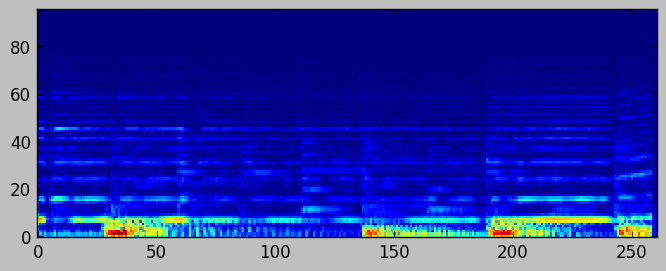

input spectrogram shape (261, 96)
label of the instrument [ 9.], representing vio


In [109]:
#let's load the first file
melspec = util.loadTensor(out_path=os.path.join(feature_dir_train,file_list[0]))
plt.imshow(np.log10(1+100*melspec.T),interpolation='none', origin='lower')
plt.show()
print 'input spectrogram shape '+str(melspec.shape)
label = util.loadTensor(out_path=os.path.join(feature_dir_train,file_list[0].replace('mel','label')))
print 'label of the instrument '+str(label)+', representing '+instruments[int(label)]

Convolutional neural networks (CNN) usually work with images of a specific size. Usually if we change the resolution or the shape of the image, we need to train a new model. Therefore, we need to cut or spectrogram into time_context (x-axis) blocks. Similarly, if we increase the resolution of the spectrogram, we have more features on the y-axis and we need to re-train the network.

In this case, the CNN models a time_context of 128 frames (128*0.011s=1.4s). We split each example in blocks of this size. We can create more data by overlapping these blocks. In this case we use an overlapping of 50 time frames. In total, we generate 3 examples (instances or training data points) from the previously loaded '.data' file. 

In [110]:
#parameters to generate blocks of data from spectrograms
time_context=128 #time context modeled by the network
overlap = 50 #overlap to generate more blocks

noinstances = np.maximum(1,int(np.ceil((float(melspec.shape[0])-time_context)/ overlap)))

print "number of instances: "+str(noinstances)

number of instances: 3


This is a function that computes the number of examples we can generate for a given file. 

We can call it for all the features '.data' files to see how many training examples we have.

In [111]:
def getNumInstances(infile,time_context=100,overlap=25):
    """
    For a single .data file computes the number of examples of size \"time_context\" that can be created
    """
    shape = util.get_shape(os.path.join(infile.replace('.data','.shape')))
    length_file = float(shape[0])
    return np.maximum(1,int(np.ceil((length_file-time_context)/ overlap))) 

noinstances=getNumInstances(infile=os.path.join(feature_dir_train,file_list[0]),time_context=time_context,overlap=overlap)
print "number of instances: "+str(noinstances)

total_noinstances = np.cumsum(np.array([0]+[ getNumInstances(os.path.join(feature_dir_train,infile),time_context=time_context,overlap=overlap) for infile in file_list], dtype=int))
print "cumulative sum of number of instances per .data file: "+str(total_noinstances)
total_points = total_noinstances[-1]
print "total number of instances "+str(total_points)

number of instances: 3
cumulative sum of number of instances per .data file: [ 0  3  6  9 12 15 18 21 24 27 30 33 36]
total number of instances 36


Similarly, we can determine the feature_size for the input features. We can read this from the '.shape' file which is associated with a '.data' file.

In [112]:
def getFeatureSize(infile):
    """
    For a single .data file return the number of feature, e.g. number of spectrogram bins
    """
    shape = util.get_shape(os.path.join(infile.replace('.data','.shape')))
    return shape[1]

feature_size = getFeatureSize(infile=os.path.join(feature_dir_train,file_list[0]))
print "feature size "+str(feature_size)

feature size 96


We use this information to allocate data for the features and the labels. 

In [113]:
floatX=np.float32
####features
features=np.zeros((total_points,time_context,feature_size),dtype=floatX)
####labels
labels = np.zeros((total_points,1),dtype=floatX)

Let's load the first .data file with index id=0 and store it in the features array.

shape of spectrogram (261, 96)
segment 0 from 0 to 128
segment 1 from 50 to 178
segment 2 from 100 to 228


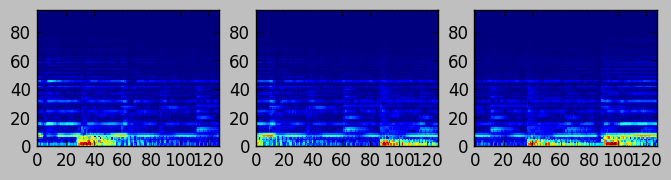

In [114]:
id = 0
spec = util.loadTensor(out_path=os.path.join(feature_dir_train,file_list[id]))
print 'shape of spectrogram '+str(spec.shape)
lab = util.loadTensor(out_path=os.path.join(feature_dir_train,file_list[id].replace(suffix_in,suffix_out)))
#we need to put the features in the self.features array starting at this index
idx_start = total_noinstances[id]
#and we stop at this index in self.feature
idx_end = total_noinstances[id+1]

#copy each block of size (time_contex,feature_size) in the self.features
idx = 0 #starting index of each block
start = 0 #starting point for each block in frames
fig, ax = plt.subplots(nrows=1,ncols=idx_end-idx_start)
while idx<(idx_end-idx_start):
    print 'segment '+str(idx) + ' from '+str(start)+ ' to '+ str(start+time_context)
    features[idx_start+idx] = spec[start:start+time_context]
    plt.subplot(idx_end-idx_start,3,idx+1) 
    plt.imshow(np.log10(1+100*features[idx_start+idx].T),interpolation='none', origin='lower')
    start = start + overlap
    idx = idx + 1
labels[idx_start:idx_end] = lab[0]
plt.show()

We populate this vector with the examples we generate from each file.

In [115]:
def fetchFile(self,id):
    #load the data files
    spec = util.loadTensor(out_path=os.path.join(self.feature_dir,self.file_list[id]))
    lab = util.loadTensor(out_path=os.path.join(self.feature_dir,self.file_list[id].replace(self.suffix_in,self.suffix_out)))
    #we need to put the features in the self.features array starting at this index
    idx_start = self.total_noinstances[id]
    #and we stop at this index in self.feature
    idx_end = self.total_noinstances[id+1]

    #copy each block of size (time_contex,feature_size) in the self.features
    idx=0 #starting index of each block
    start = 0 #starting point for each block in frames
    while idx<(idx_end-idx_start):
        self.features[idx_start+idx] = spec[start:start+self.time_context]
        start = start + self.overlap
        idx = idx + 1
    self.labels[idx_start:idx_end] = lab[0]
    spec = None
    lab = None

Wrapping everything together, we can put all these routines in a class, which reads the data from the disk and returns batches for the training. 

If we have a total number of 36 training examples we keep 20% for validation(train_percent=0.8), then we are left with 29 training examples. With a batch_size=6, this means that we will have 4 batches of 6 examples each.

In [116]:
import dataset
from dataset import MyDataset

db=MyDataset(feature_dir=feature_dir_train, batch_size=6, time_context=128, overlap=50, 
             suffix_in='_mel_',suffix_out='_label_',floatX=np.float32,train_percent=0.8)
print "total number of instances: "+str(db.total_points)
print "batch_size: "+str(db.batch_size)
print "iteration size: "+str(db.iteration_size)
print "feature shape: "+str(db.features.shape)
print "labels shape: "+str(db.labels.shape)
print "feature validation shape: "+str(db.features_valid.shape)
print "labels validation shape: "+str(db.labels_valid.shape)

total number of instances: 29
batch_size: 6
iteration size: 4
feature shape: (29, 128, 96)
labels shape: (29, 1)
feature validation shape: (7, 128, 96)
labels validation shape: (7, 1)


We can even implement a '__call__' method which returns a training batch each time the object is called. 

What do we return each call? We keep track of the current example using the iteration_step and we shift with batch_size. 

When working with CNN, we should add an axis for the channels: 3 (R,G,B) for image processing and in 1 in this case as the spectrogram can be regarded as a monochromatic image.

In [117]:
#what do we return at each call
feat=db.features[db.iteration_step*db.batch_size:(db.iteration_step+1)*db.batch_size]
feat=db.features[db.iteration_step*db.batch_size:(db.iteration_step+1)*db.batch_size,np.newaxis]
lab=db.labels[db.iteration_step*db.batch_size:(db.iteration_step+1)*db.batch_size]

This is what the call method returns at each interation step. We can plot the first example, which is different every time because of the batch shuffling. 

iteration step 0
(6, 1, 128, 96)
(6, 1)
instrument: cel


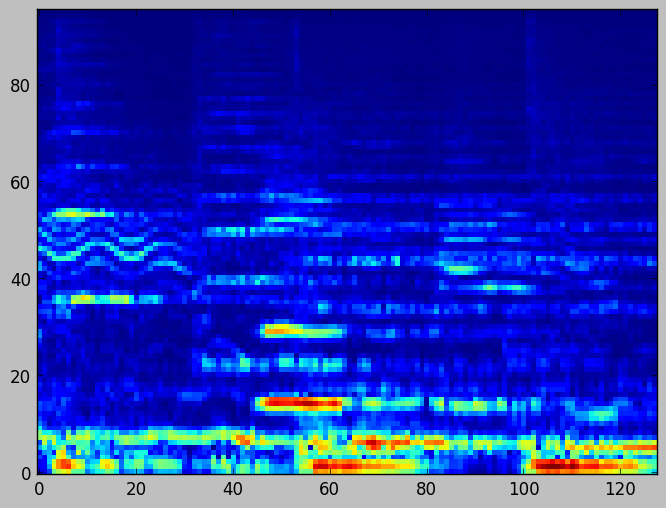

In [118]:
features,labels = db()
print "iteration step "+str(db.iteration_step)
print features.shape
print labels.shape
print 'instrument: '+instruments[int(labels[1,0])]
plt.imshow(np.log10(1+100*features[2,0,:,:].T),interpolation='none', origin='lower')
plt.show()

What if you don't need the __call__ method and you want the object to return the whole data at the same time? 

We can do this with db.getData() and db.getValidation().

In [119]:
features, labels, features_valid, labels_valid = db.getData()
print "training features shape "+str(features.shape)
print "validation features shape "+str(features_valid.shape)
features_valid, labels_valid = db.getValidation()

training features shape (29, 128, 96)
validation features shape (7, 128, 96)
